# Right-hand side vector power series approximation

Using [2] for reference, we try their approximation for the initialization of the right-hand side vector of the linear system $b$


In [46]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation, RYGate
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *

In [2]:
size = 2
qr = QuantumRegister(size,name='q')
qa = AncillaRegister(1,name="a")
qc = QuantumCircuit(qr,qa)

for i in range(size):
    qc.h(i)
# p(x) = x^2 + x + 1

qc.ry(2*1,qa)
qc.cry(2*(4+2),qr[1],qa)
qc.cry(2*(1+1),qr[0],qa)
qc.mcry(2*4,qr[:],qa)

#qc.initialize(vector/np.linalg.norm(vector),range(2),None)

print(qc.draw())

st = Statevector(qc)

st.data.real[4:]

       ┌───┐                                                  
q_0: ──┤ H ├────────────────■───────────────■──────────────■──
       ├───┤                │               │              │  
q_1: ──┤ H ├──────■─────────┼───────────────■──────────────■──
     ┌─┴───┴─┐┌───┴────┐┌───┴───┐┌───────┐┌─┴─┐┌────────┐┌─┴─┐
  a: ┤ Ry(2) ├┤ Ry(12) ├┤ Ry(4) ├┤ Ry(4) ├┤ X ├┤ Ry(-4) ├┤ X ├
     └───────┘└────────┘└───────┘└───────┘└───┘└────────┘└───┘


array([0.42073549, 0.07056   , 0.3284933 , 0.21008352])

In [119]:
def parse_func(poly_str):
    # Remove spaces
    poly_str = poly_str.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    poly_str = poly_str.replace('-', '+-')
    if poly_str[0] == '+':
        poly_str = poly_str[1:]
    
    # Split the string into terms
    terms = poly_str.split('+')
    
    coefficients = {}
    max_degree = 0
    
    for term in terms:
        if 'x' in term:
            if '^' in term:
                coef, exp = term.split('x^')
                exp = int(exp)
            else:
                coef, exp = term.split('x')
                exp = 1
            
            if coef in ('', '+'):
                coef = 1
            elif coef == '-':
                coef = -1
            else:
                coef = int(coef)
        else:
            coef = int(term)
            exp = 0
        
        coefficients[exp] = coef
        if exp > max_degree:
            max_degree = exp
    
    # Fill missing degrees with 0
    all_coefficients = [coefficients.get(i, 0) for i in range(max_degree + 1)]
    return all_coefficients,max_degree

def value_func(coefs,nb):
    
    if not isinstance(coefs,np.ndarray):
        coefs = np.array(coefs)
    
    size = 2**nb
    
    pol=[]
    for i in range(size):
        aux = 0
        for j in range(1,len(coefs)):
            aux +=coefs[j]*i**j
        pol.append(aux)     
    
    return pol

def loc_ancilla(qc: QuantumCircuit):
    i=0
    pos=0
    while True:        
        if isinstance(qc.qregs[i],AncillaRegister):
            break
        else:
            pos+= qc.qregs[i].size
            i+=1
            
    return pos
    
def ccry(qc:QuantumCircuit,theta: float,control: list,target):
    ry = RYGate(theta).control(len(control))
    if isinstance(control,list):
        if isinstance(target,list):
            qc.append(ry,control+target)
        elif isinstance(target,AncillaRegister):
            qc.append(ry,control+[loc_ancilla(qc)])
            
    return qc

def b_state(nb: int,function: str,c: float = 1) -> QuantumCircuit:
    """Defines the b state from an approximation polynomic function
    
    Args:
        `nb`: The number of qubits needed to represent the vector
        `function`: A string representing the function. The style must be: 'ax^n+bx^n-1+...+z'. Where a,b,...,z are the amplitudes.
        
    """
    qr = QuantumRegister(nb,name="b")
    qa = AncillaRegister(1,name='a')
    qc = QuantumCircuit(qr,qa)
    
    qc.h(qr[:])
    
    # Processing of `function`
    ampl,D = parse_func(function)
    
    # Value of `function`
    pol = value_func(ampl,nb)
    
    if ampl[0]!=0:
        qc.ry(D*ampl[0]*c,qa)
    
    size = 2**nb
    
    for i in range(1,size):        
        if (np.floor(np.log2(i))==np.ceil(np.log2(i))):
            if pol[i]!=0:
                qc.cry(D*pol[i]*c,qr[int(np.log2(i))],qa)
        else:
            bin_aux = bin(i)[2:]
            index = [len(bin_aux) - 1 - j for j, digit in enumerate(bin_aux) if digit == '1' ]
            # I dont remember why this 2**i, but it made sense in the moment i coded it
            aux = [pol[2**i] for i in index]
            elem = pol[i]-np.sum(aux)
            if elem != 0:
                # qc.mcry(D*elem*c,index,qa) 
                qc = ccry(qc,D*elem*c,index,qa)    
    return qc

In [ ]:
def b_from_func(function,size):
    coef,dg = parse_func(function)
    b = []
    for i in range(size):
        aux = 0
        for j in range(dg+1):
            aux+=coef[j]*((i/(size-1))**j)
        b.append(aux)
    return b

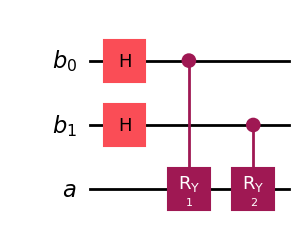

In [104]:
b = b_state(2,'x',1)
b.draw('mpl')

In [151]:
function = 'x'
size = 2
b = b_state(2,function,1)
state = Statevector(b)
state = state.data.real[4:]
state/np.linalg.norm(state)

array([0.        , 0.34483742, 0.60524662, 0.71747033])

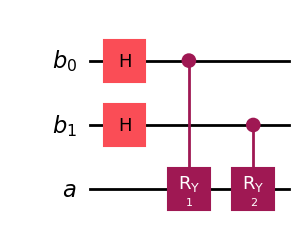

In [152]:
b.draw('mpl')

In [153]:
arr = np.array(b_from_func(function,size**2))
qc = QuantumCircuit(2)
qc.initialize(arr/np.linalg.norm(arr))
state = Statevector(qc)
print(state.data.real)

[0.         0.26726124 0.53452248 0.80178373]
